# 1)데이터셋 다운

In [1]:
from google.colab import files
files.upload() #Kaggle token 넣기

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tonydon2","key":"3b114479249a978b631a89d32c0f170e"}'}

In [2]:
ls -1ha kaggle.json #token 확인

kaggle.json


In [3]:
#Colab에 Kaggle 계정 연동
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
#Colab으로 안면 이미지 데이터셋 바로 받기 
!kaggle datasets download -d jangedoo/utkface-new

 97% 321M/331M [00:02<00:00, 131MB/s]
100% 331M/331M [00:02<00:00, 130MB/s]


In [5]:
#안면 이미지 데이터셋 unzip
!unzip /content/utkface-new.zip 

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327523.jpg.chip.jp

# 2)데이터셋 불러오기 및 확인

In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPool2D, Activation, Dropout, Lambda, Dense, Flatten, Input
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras import backend as k
from glob import glob
import seaborn as sns

In [7]:
folder_name = 'UTKFace'

In [8]:
dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((g, i) for i, g in dataset_dict['race_id'].items())

In [9]:
def parse_dataset(dataset_path, ext='jpg'):

    def parse_info_from_file(path):
        try: #이미지 파일 path를 가져와 파일명 parsing 후 나이,성별,인종 정보 추출 
            filename = os.path.split(path)[1] 
            filename = os.path.splitext(filename)[0] 
            age, gender, race, _ = filename.split('_') 

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex: #예외가 발생했을 때 처리하는 코드
            return None, None, None
        
    files = glob(os.path.join(dataset_path, "*.%s" % ext))#os.path.join()으로 파일 path조합
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']
    df = df.dropna()
    
    return df

In [10]:
df = parse_dataset(folder_name)

In [11]:
df.head()

,age,gender,race,file
0,5.0,male,white,UTKFace/5_0_0_20170110213322127.jpg.chip.jpg
1,28.0,male,black,UTKFace/28_0_1_20170116203348523.jpg.chip.jpg
2,14.0,female,white,UTKFace/14_1_0_20170109204131257.jpg.chip.jpg
3,16.0,male,white,UTKFace/16_0_0_20170116235030195.jpg.chip.jpg
4,48.0,male,white,UTKFace/48_0_0_20170117164541702.jpg.chip.jpg


In [12]:
import plotly.graph_objects as go

def plot_distribution(pd_series):
    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()
    
    pie_plot = go.Pie(labels=labels, values=counts, hole=.3)
    fig = go.Figure(data=[pie_plot])
    fig.update_layout(title_text='Distribution for %s' % pd_series.name)
    
    fig.show()

In [13]:
#데이터셋 내의 인종 비율
plot_distribution(df['race'])
#백인 비율이 가장 많고 그 다음이 흑인, 인디언, 아시안 순

In [14]:
#데이터셋의 남녀 비율
plot_distribution(df['gender'])
#남자가 조금 많은

In [15]:
#데이터셋 내의 연령대 비율
bins = [0, 10, 20, 30, 40, 60, 80, np.inf]
names = ['<10', '10-20', '20-30', '30-40', '40-60', '60-80', '80+']
age_binned = pd.cut(df['age'], bins, labels=names)
plot_distribution(age_binned)
#20~30대가 가장 많고 80대 이상이 가장 적음

# 3)CNN 모델 만들기

In [16]:
#학습을 위한 데이터 셋을 만들기 위해 데이터를 np.array형태로 저장
images = []
age = []
gender = []
for img in os.listdir(folder_name): #folder_name의 디렉토리 내 모든 파일과 디렉토리 list를 하나씩 접근
  ages = img.split("_")[0]
  genders = img.split("_")[1]
  img = cv2.imread(str(folder_name)+"/"+str(img))#이미지 로딩은 파일명
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)#BGR색상 이미지를 RGB이미지로 변환(openCV가 이미지 불러오는 방식 떄문에)
  img = img
  images.append(np.array(img))#파일을 읽어 넘파이array로 변환
  age.append(np.array(ages))
  gender.append(np.array(genders))
 

age = np.array(age,dtype=np.int64)
images = np.array(images)   
gender = np.array(gender,np.uint64)

print(age)
print(images)


[ 5 28 14 ... 24 35 36]
[[[[ 31  31  33]
   [ 31  31  33]
   [ 31  31  33]
   ...
   [ 36  33  42]
   [ 36  33  42]
   [ 35  32  41]]

  [[ 32  32  34]
   [ 32  32  34]
   [ 32  32  34]
   ...
   [ 37  34  43]
   [ 36  33  42]
   [ 36  33  42]]

  [[ 32  32  34]
   [ 32  32  34]
   [ 32  32  34]
   ...
   [ 37  34  43]
   [ 37  34  43]
   [ 37  34  43]]

  ...

  [[189 192 171]
   [190 193 172]
   [192 194 173]
   ...
   [254 254 254]
   [254 254 254]
   [254 254 254]]

  [[189 192 171]
   [190 193 172]
   [191 193 172]
   ...
   [254 254 254]
   [254 254 254]
   [254 254 254]]

  [[189 192 171]
   [190 193 172]
   [191 193 172]
   ...
   [254 254 254]
   [254 254 254]
   [254 254 254]]]


 [[[108 101 109]
   [108 101 109]
   [108 101 109]
   ...
   [ 10  11  16]
   [ 10  11  16]
   [ 11  12  17]]

  [[105  98 106]
   [105  98 106]
   [105  98 106]
   ...
   [ 10  11  16]
   [ 10  11  16]
   [ 11  12  17]]

  [[100  93 101]
   [101  94 102]
   [101  94 102]
   ...
   [ 10  11  16]
   [

In [17]:
#scikit-learn의 model_selection 패키지 안에 train_test_split 모듈을 활용하여 손쉽게 학습 데이터 셋 (train set)과 테스트 셋 (test set)을 분리
#모델 학습과 검증을 위해 age, images, gender에 각각 저장된 데이터를 Train Set : Validation Set : Test Set = 6:2:2 비율로 나누기

#sklearn,train_test_split(분할시킬 데이터 입력,분할시킬 데이터 입력, 데이터 분할 시 셔플이 이루어지는데 이용할 시드값, 테스트 데이터셋 비율 )
#나이정보
x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(images, age, random_state=42, test_size=0.4) #나이 데이터를 훈련용 6, 테스트셋 4 비율로 나누기
x_valid_age , x_test_age  , y_valid_age, y_test_age = train_test_split(x_test_age, y_test_age, random_state=42, test_size=0.5) #위에서 나눈 테스트셋을 다시 5:5 비율로 나누기

#성별정보
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(images, gender, random_state=42, test_size = 0.4)
x_valid_gender , x_test_gender  , y_valid_gender, y_test_gender = train_test_split(x_test_gender, y_test_gender, random_state=42, test_size=0.5)

In [18]:
#학습비율 설정
#신경망 학습 목적은 손실함수 값을 가능한 한 낮추는 매개변수를 찾는 것. 매개변수 최적값을 찾기 위해 
#Adam optimizer 사용해 최적값 찾기
from tensorflow.keras.optimizers import Adam
init_lr = 1e-4 #initial learning rate 0.0004
epochs = 50
opt = Adam(lr=init_lr, decay=init_lr / epochs) 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [20]:
#Call Back 함수로 ModelCheckpoint 와 Early Stopping 사용
#Model Checkpoint는 체크포인트를 저장, Early stopping은 validation loss가 더 개선 없을 때 과적합 방지하기 위해 훈련을 중단하는 용도
callbacks = [EarlyStopping(monitor='val_loss',
                                           patience=5), #val loss 기준으로 다음 5회 동안 val loss가 더 이상 줄지 않으면 학습을 종료
             ModelCheckpoint(filepath='./best_model_{val_loss:.2f}.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]

In [21]:
#https://tykimos.github.io/2017/01/27/CNN_Layer_Talk/
#컨볼루션 신경망 레이어 구조를 비주얼하게 보려면 위의 링크 참조

#keras이용
age_model = Sequential([
    Conv2D(128, kernel_size =3, input_shape=(200,200,3)), #컨볼루션 필터 수, 3x3 커널, 행/열/채널 수(컬러RGB는 3)
    BatchNormalization(),#학습 과정에서 각 배치 단위 별로 데이터가 다양한 분포를 가지더라도 각 배치별로 평균과 분산을 이용해 정규화 하는 것
    Activation('relu'),#ReLU 는 입력이 0을 넘으면 그 입력을 그대로 출력하고, 0 이하면 0을 출력하는 함수 => 단순해서 연산 비용이 크지 않음.(연산비용이 크다는 것은 속도가 그만큼 느리다는 의미) 
    MaxPool2D(pool_size=3, strides=2),#이미지 크기 축소하는 함수 => m x n 행렬로 구성된 가중치, 입력 데이터에 커널을 적용할 때 이동할 간격을 의미(스트라이드 값이 커지면 출력 크기는 작아짐)
    Conv2D(128, kernel_size =3),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Conv2D(256, kernel_size =3),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),#사소한 변화 무시
    Conv2D(512, kernel_size =3),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Flatten(),#영상을 1차원으로 바꾸기
    Dropout(0.25),
    Dense(512, activation  = 'relu'),#
    Dense(1, activation = 'linear', name = 'age')
])
age_model.compile(loss="mse", optimizer=opt, metrics = ['mae'])
#↓참고이미지

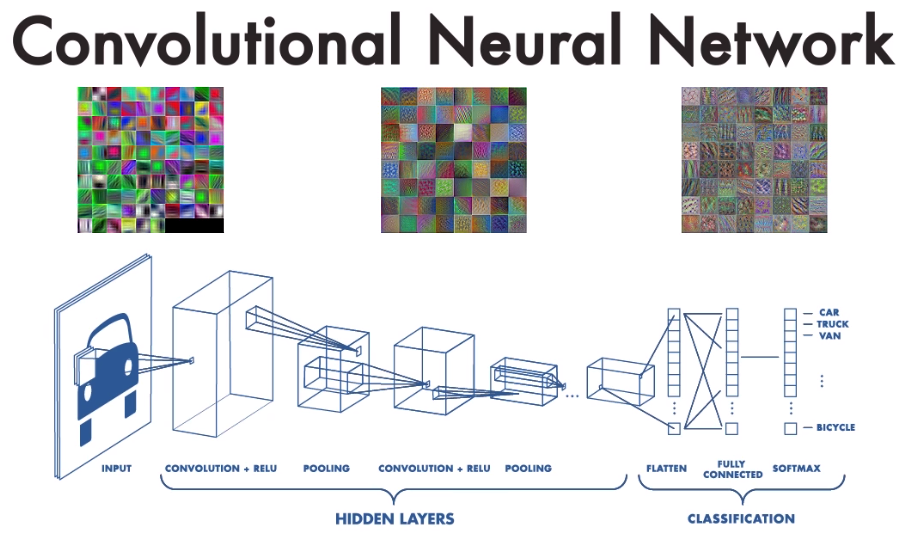

In [22]:
gender_model = Sequential([
    Conv2D(36, kernel_size=3,input_shape=(200,200,3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Conv2D(64, kernel_size=3),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Conv2D(128, kernel_size=3),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Conv2D(256, kernel_size=3),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Conv2D(512, kernel_size=3),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Flatten(),
    Dropout(0.25),
    Dense(512, activation  = 'relu'),
    Dense(1, activation = 'sigmoid', name = 'gender')
])

gender_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
#↓참고이미지

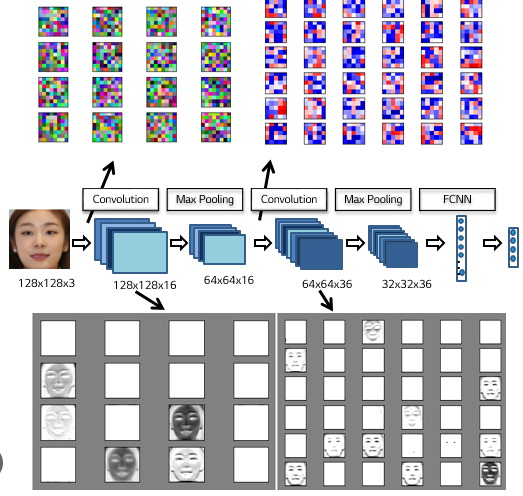

In [23]:
#나이 학습을 위한 age_model
history_age = age_model.fit(x_train_age, y_train_age,
                        validation_data=(x_valid_age, y_valid_age), batch_size = 32, epochs=50, callbacks = callbacks)

Epoch 1/50
445/445 [==============================] - 29s 41ms/step - loss: 191.2595 - mae: 10.3597 - val_loss: 133.2485 - val_mae: 8.6007
Epoch 2/50
445/445 [==============================] - 17s 38ms/step - loss: 120.1868 - mae: 8.2259 - val_loss: 111.3139 - val_mae: 7.5761
Epoch 3/50
445/445 [==============================] - 17s 38ms/step - loss: 98.9877 - mae: 7.4090 - val_loss: 102.3039 - val_mae: 7.3297
Epoch 4/50
445/445 [==============================] - 17s 38ms/step - loss: 84.4436 - mae: 6.8599 - val_loss: 101.0754 - val_mae: 7.6849
Epoch 5/50
445/445 [==============================] - 17s 38ms/step - loss: 75.3065 - mae: 6.4750 - val_loss: 91.6301 - val_mae: 7.2887
Epoch 6/50
445/445 [==============================] - 17s 38ms/step - loss: 68.6732 - mae: 6.2002 - val_loss: 82.6835 - val_mae: 6.7429
Epoch 7/50
445/445 [==============================] - 17s 37ms/step - loss: 62.1043 - mae: 5.9087 - val_loss: 86.1237 - val_mae: 7.1249
Epoch 8/50
445/445 [=====================

In [24]:
#성별 학습을 위한 gender_model
history_gender = gender_model.fit(x_train_gender, y_train_gender,
                        validation_data=(x_valid_gender, y_valid_gender), batch_size=32, callbacks = callbacks, epochs=50)

Epoch 1/50
445/445 [==============================] - 12s 23ms/step - loss: 0.4916 - accuracy: 0.7833 - val_loss: 0.3411 - val_accuracy: 0.8496
Epoch 2/50
445/445 [==============================] - 9s 21ms/step - loss: 0.3095 - accuracy: 0.8619 - val_loss: 0.2962 - val_accuracy: 0.8735
Epoch 3/50
445/445 [==============================] - 9s 20ms/step - loss: 0.2614 - accuracy: 0.8858 - val_loss: 0.2968 - val_accuracy: 0.8652
Epoch 4/50
445/445 [==============================] - 9s 21ms/step - loss: 0.2257 - accuracy: 0.9055 - val_loss: 0.2614 - val_accuracy: 0.8811
Epoch 5/50
445/445 [==============================] - 9s 21ms/step - loss: 0.1955 - accuracy: 0.9201 - val_loss: 0.2502 - val_accuracy: 0.8941
Epoch 6/50
445/445 [==============================] - 9s 20ms/step - loss: 0.1733 - accuracy: 0.9310 - val_loss: 0.2819 - val_accuracy: 0.8787
Epoch 7/50
445/445 [==============================] - 9s 20ms/step - loss: 0.1518 - accuracy: 0.9396 - val_loss: 0.2662 - val_accuracy: 0.891

In [33]:
gender_model.save('gender_model.h5')

In [34]:
age_model.save('age_model.h5')

In [28]:
from google.colab import files

files.download('gender_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
files.download('age_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
history_age

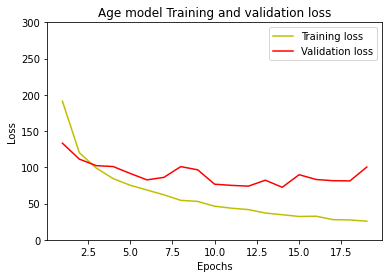

In [39]:
#Loss(손실값) = 결과값 - 예측 값, Loss값이 작을 수록 좋은 모델
history = history_age
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Age model Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,300)
plt.legend()
plt.show()
#training Loss는 지속적으로 감소하고 있고, validation loss는 감소하다가 어느 순간부터 증가하는 추세로 바뀜.
#이는 epoch가 증가할수록 train dataset에 딱 맞는 정답을 학습하려고 하기 때문에
#validation에서는 오히려 성능 저하를 보이는 과적합이라고 볼 수 있다.

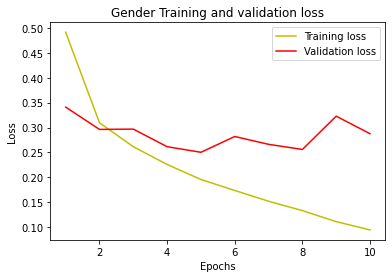

In [40]:
history = history_gender
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Gender Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')#
plt.legend()
plt.show()

# 4)모델 성능 확인하기

In [41]:
len(x_test_age)

4742

In [42]:
y_test_age[0]

48

In [43]:
age_preds = age_model.predict(x_test_age)

149/149 [==============================] - 2s 10ms/step


In [44]:
gender_preds = gender_model.predict(x_test_gender)

149/149 [==============================] - 1s 5ms/step


In [45]:
from sklearn.metrics import mean_absolute_error, accuracy_score, recall_score, precision_score, confusion_matrix, classification_report

In [46]:
#나이 : 약 6살의 오차 평균
age_mae = mean_absolute_error(y_test_age, age_preds)

age_mae

6.923325052557931

In [47]:
#성별 : 약 90%의 정확도
gender_accuracy = accuracy_score(y_test_gender, np.round(gender_preds))

gender_accuracy

0.8939266132433572

(array([2184.,  173.,  115.,   90.,   88.,   76.,   95.,  115.,  161.,
        1645.]),
 array([2.3058588e-11, 9.9999487e-02, 1.9999897e-01, 2.9999846e-01,
        3.9999795e-01, 4.9999744e-01, 5.9999692e-01, 6.9999641e-01,
        7.9999590e-01, 8.9999539e-01, 9.9999487e-01], dtype=float32),
 <a list of 10 Patch objects>)

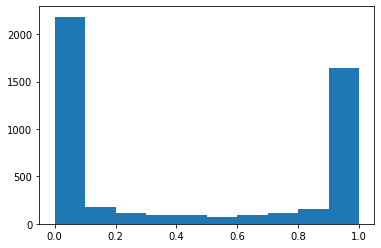

In [48]:
plt.hist(gender_preds.ravel())

In [49]:
print(classification_report(y_test_gender,np.round(gender_preds)))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      2529
           1       0.91      0.86      0.88      2213

    accuracy                           0.89      4742
   macro avg       0.90      0.89      0.89      4742
weighted avg       0.89      0.89      0.89      4742



In [50]:
confusion_matrix(y_test_gender,np.round(gender_preds))

array([[2338,  191],
       [ 312, 1901]])

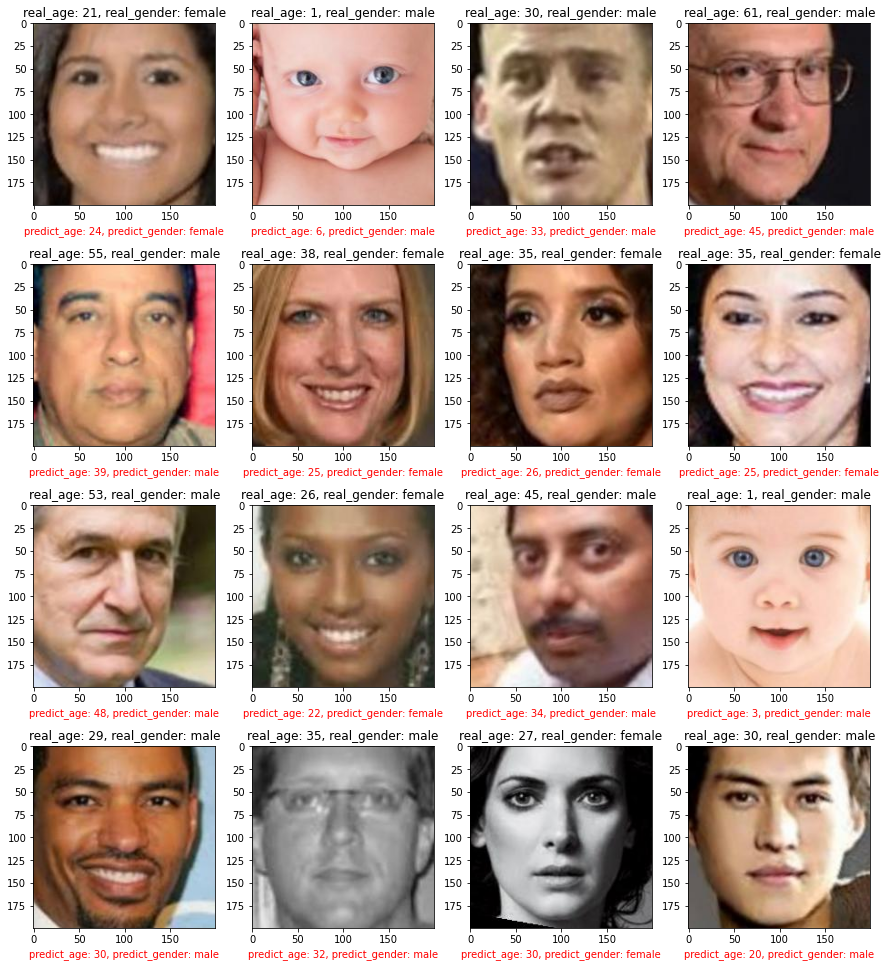

In [51]:
#Test Set에서 랜덤으로 16개의 사진 출력
#사진 상단에는 실제 정답, 하단에는 예측한 값 표기

import math
n=16
random_indices = np.random.choice(len(x_test_age), size=n)
n_cols = 4
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 17))
for i, x in enumerate(random_indices):
   ax = axes.flat[i]
   ax.imshow(x_test_age[x])
   real_age = y_test_age[x]
   predict_age = age_preds[x]
   if y_test_gender[x] == 1:
     real_gender = 'female'
   else:
     real_gender = 'male'
   if np.round(gender_preds[x]) == 1:
     predict_gender = 'female'
   else:
     predict_gender ='male' 
   ax.set_title('real_age: {}, real_gender: {}'.format(int(real_age),real_gender))
   ax.set_xlabel('predict_age: {}, predict_gender: {}'.format(int(predict_age),predict_gender))
   ax.xaxis.label.set_color('red')
